In [1]:
library('ggplot2') # Visualisation
library('ggthemes') # Visualisation
library('scales') # Visualisation
library('dplyr') # Data manipulation
library('mice') # Imputation
# rpart can also be used for missing value imputation
library('randomForest') # Classification algorithm


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin



In [2]:
train <- read.csv('./dataset/train.csv', stringsAsFactors = F)
test <- read.csv('./dataset/test.csv', stringsAsFactors = F)

full <- bind_rows(train, test) # bind the training and test data

str(full) #structure

'data.frame':	1309 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : chr  "Braund, Mr. Owen Harris" "Cumings, Mrs. John Bradley (Florence Briggs Thayer)" "Heikkinen, Miss. Laina" "Futrelle, Mrs. Jacques Heath (Lily May Peel)" ...
 $ Sex        : chr  "male" "female" "female" "female" ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : chr  "A/5 21171" "PC 17599" "STON/O2. 3101282" "113803" ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : chr  "" "C85" "" "C123" ...
 $ Embarked   : chr  "S" "C" "S" "S" ...


In [3]:
# Grab the title from passenger names
full$Title <- gsub('(.*,)|(\\..*)', '', full$Name)

table(full$Sex, full$Title)

        
          Capt  Col  Don  Dona  Dr  Jonkheer  Lady  Major  Master  Miss  Mlle
  female     0    0    0     1   1         0     1      0       0   260     2
  male       1    4    1     0   7         1     0      2      61     0     0
        
          Mme  Mr  Mrs  Ms  Rev  Sir  the Countess
  female    1   0  197   2    0    0             1
  male      0 757    0   0    8    1             0

In [4]:
rare_title <- c('Dona', 'Lady', 'the Countess','Capt', 'Col', 'Don', 
                'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer')
full$Title[full$Title == 'Mlle'] <- 'Miss'
full$Title[full$Title == 'Ms'] <- 'Miss'
full$Title[full$Title == 'Mme'] <- 'Mrs'
full$Title[full$Title %in% rare_title] <- 'Rare Title'

table(full$Sex, full$Title)

        
          Capt  Col  Don  Dona  Dr  Jonkheer  Lady  Major  Master  Miss  Mlle
  female     0    0    0     1   1         0     1      0       0   260     2
  male       1    4    1     0   7         1     0      2      61     0     0
        
          Mme  Mr  Mrs  Ms  Rev  Sir  the Countess
  female    1   0  197   2    0    0             1
  male      0 757    0   0    8    1             0

In [5]:
# Grab the surname from the passenger name
full$Surname <- sapply(full$Name, function(x) strsplit(x, split = '[,.]')[[1]][1])

In [6]:
# SibSp Sibling/Spouse  Parch Parent/Children
# FamilySize including the passenger
full$Fsize <- full$SibSp + full$Parch + 1

full$Family <- paste(full$Surname, full$Fsize, '_')

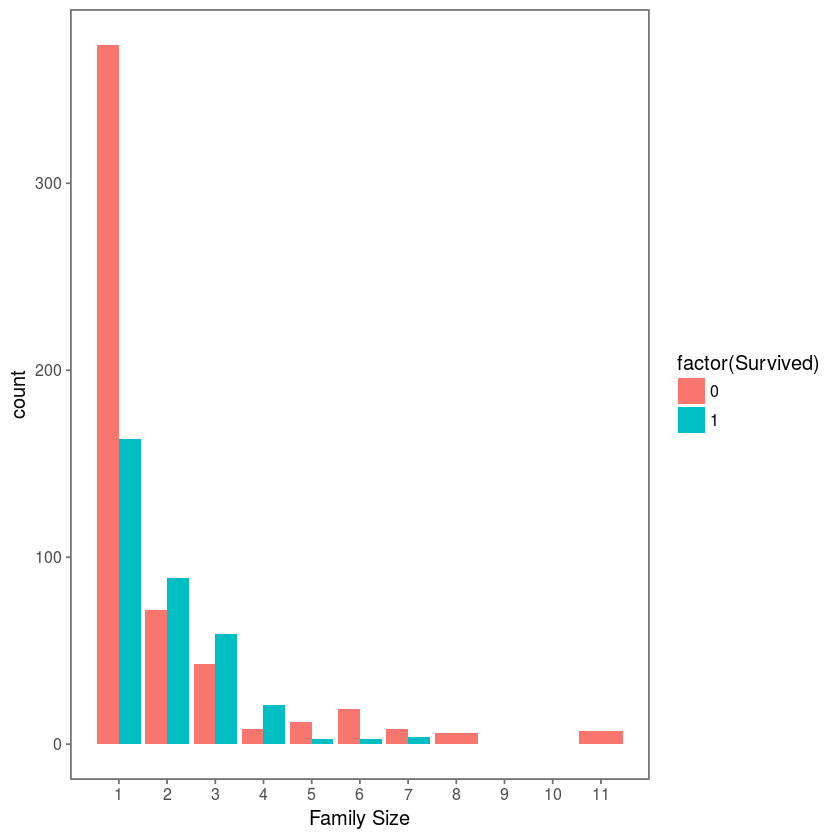

In [7]:
#  Plot the relationship b/w FamilySize and Survival on the training data
ggplot(full[1:891,], aes(x = Fsize, fill = factor(Survived))) +
  geom_bar(stat='count', position='dodge') +
  scale_x_continuous(breaks=c(1:11)) +
  labs(x = 'Family Size') +
  theme_few()

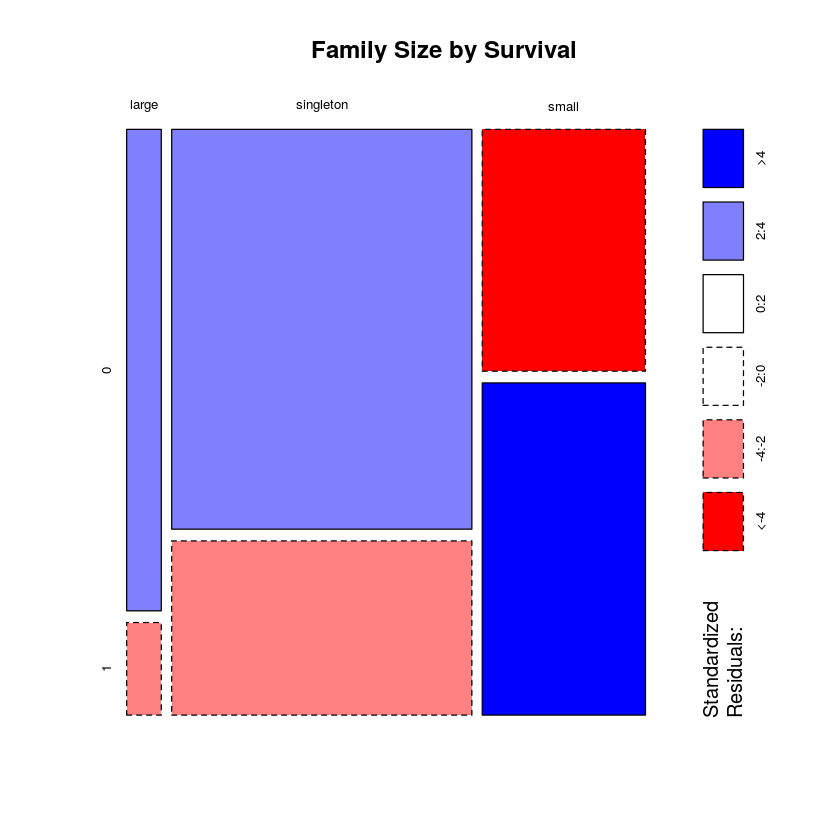

In [8]:
# Fsize == 1 & Fsize > 4 have lower rate of survivale
# Se we discritize family size.
full$FsizeD[full$Fsize == 1]<- 'singleton'
full$FsizeD[full$Fsize < 5 & full$Fsize > 1] <- 'small'
full$FsizeD[full$Fsize > 4] <- 'large'

mosaicplot(table(full$FsizeD, full$Survived), main = "Family Size by Survival", shade = T)

In [9]:
head(full$Cabin, 28)

[1] ""            "C85"         ""            "C123"        ""           
 [6] ""            "E46"         ""            ""            ""           
[11] "G6"          "C103"        ""            ""            ""           
[16] ""            ""            ""            ""            ""           
[21] ""            "D56"         ""            "A6"          ""           
[26] ""            ""            "C23 C25 C27"

In [10]:
strsplit(full$Cabin[2], NULL)

[[1]]
[1] "C" "8" "5"

In [11]:
full$Deck <- factor(sapply(full$Cabin, function(x) strsplit(x, NULL)[[1]][1]))

In [12]:
full[c(62, 830),]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname,Fsize,Family,FsizeD,Deck
62,62,1,1,"Icard, Miss. Amelie",female,38,0,0,113572,80,B28,,Miss,Icard,1,Icard 1 _,singleton,B
830,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62,0,0,113572,80,B28,,Mrs,Stone,1,Stone 1 _,singleton,B


Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”

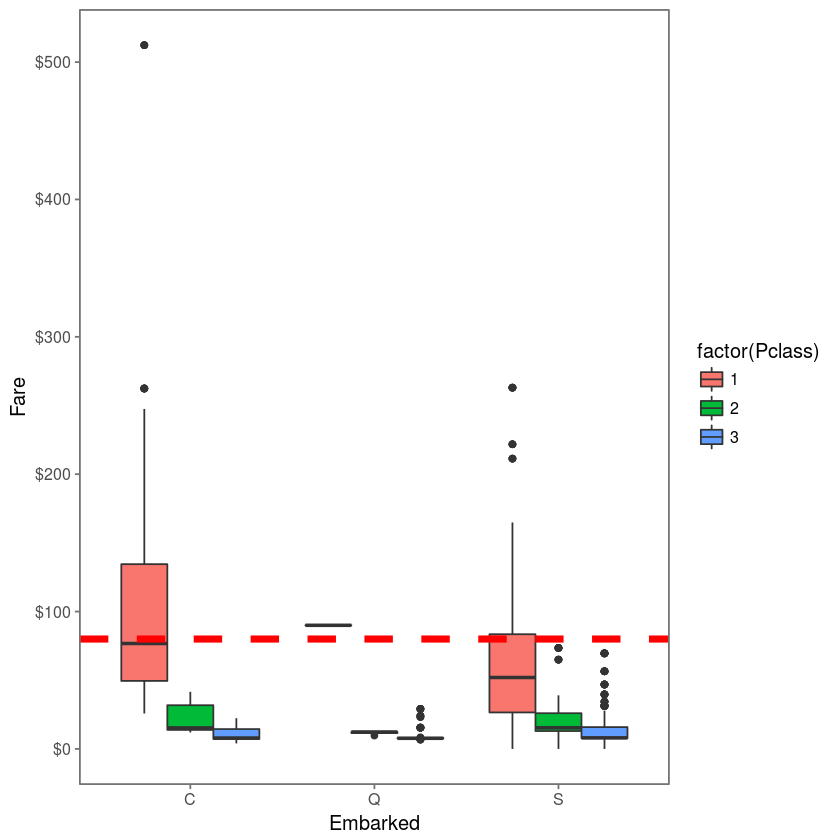

In [13]:
# Get rid of our missing passenger ID's
embark_fare <- full %>% filter(PassengerId != 62 & PassengerId != 830)

ggplot(embark_fare, aes(x = Embarked, y = Fare, fill = factor(Pclass)))+
    geom_boxplot()+
    geom_hline(aes(yintercept = 80),
               colour= 'red', linetype = 'dashed', lwd = 2)+
    scale_y_continuous(labels = dollar_format())+
    theme_few()

In [14]:
# Since their fare was $80 for 1st class, they most likely embarked from 'C'
full$Embarked[c(62, 830)] <- 'C'

Warning message:
“Removed 1 rows containing non-finite values (stat_density).”

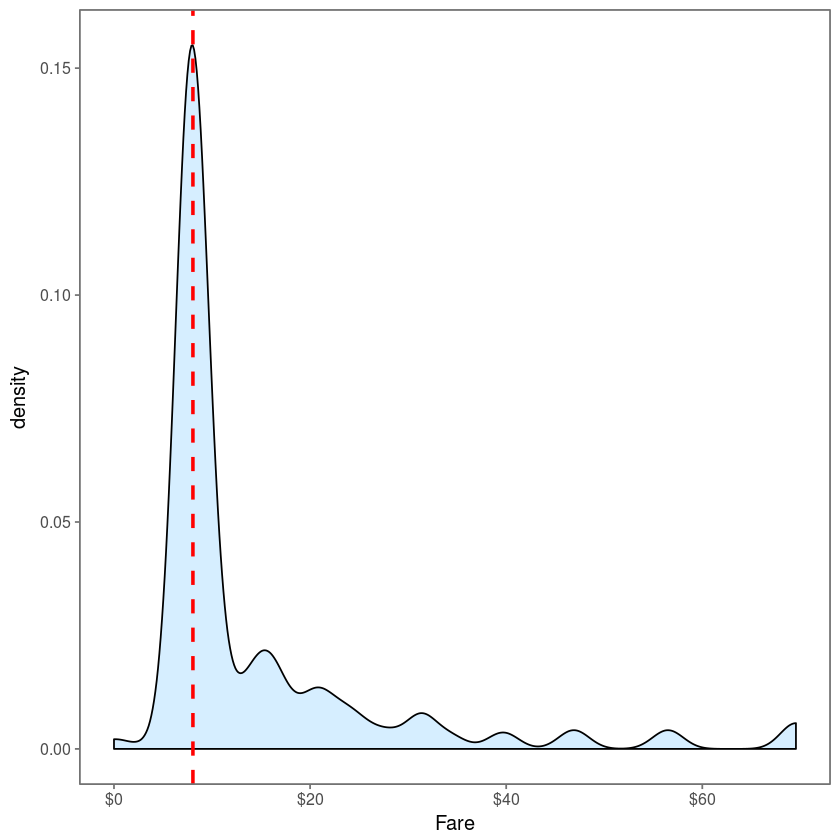

In [15]:
# full[1044,]
ggplot(full[full$Pclass == '3' & full$Embarked == 'S', ],aes(x = Fare))+
    geom_density(fill = '#99d6ff' ,alpha = 0.4)+
    geom_vline(aes(xintercept = median(Fare, na.rm = T)),
          colour = 'red', linetype = 'dashed', lwd = 1)+
    scale_x_continuous(labels = dollar_format())+
    theme_few()

In [16]:
# Replace missing fare value with median fare for class/embarkment
full$Fare[1044] <- median(full[full$Pclass == '3' & full$Embarked == 'S', ]$Fare, na.rm = TRUE)

In [17]:
# Make variables as factors
factor_vars <- c('PassengerId', 'Pclass', 'Sex', 'Embarked', 'Title', 'Surname', 'Family', 'FsizeD')
full[factor_vars] <- lapply(full[factor_vars], function(x) as.factor(x))

set.seed(129)

# Using mice for imputation, we can also use rpart (recursive partitioning for regression)
# Multivariate Imputations by Chained Equations
mice_mod <- mice(full[, !names(full) %in% c('PassengerId', 'Name', 'Ticket', 'Cabin', 'Family', 'Surname', 'Survived')], method = 'rf')


 iter imp variable
  1   1  Age  Deck
  1   2  Age  Deck
  1   3  Age  Deck
  1   4  Age  Deck
  1   5  Age  Deck
  2   1  Age  Deck
  2   2  Age  Deck
  2   3  Age  Deck
  2   4  Age  Deck
  2   5  Age  Deck
  3   1  Age  Deck
  3   2  Age  Deck
  3   3  Age  Deck
  3   4  Age  Deck
  3   5  Age  Deck
  4   1  Age  Deck
  4   2  Age  Deck
  4   3  Age  Deck
  4   4  Age  Deck
  4   5  Age  Deck
  5   1  Age  Deck
  5   2  Age  Deck
  5   3  Age  Deck
  5   4  Age  Deck
  5   5  Age  Deck


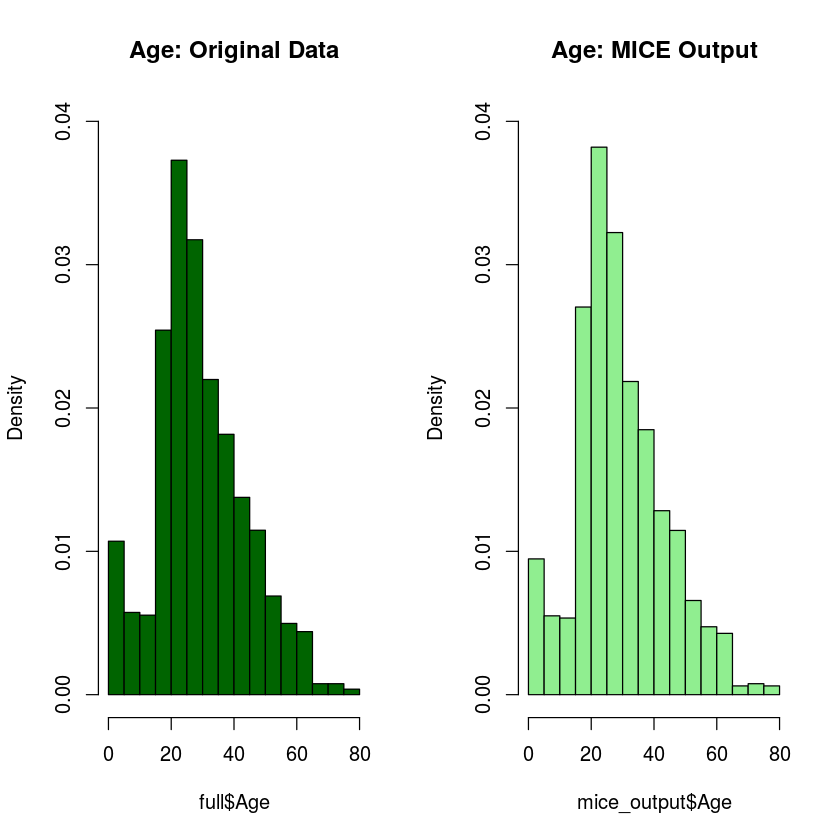

In [18]:
mice_output <- complete(mice_mod)

# Compare & Plot age distributions
par(mfrow = c(1,2))
hist(full$Age, freq = F, main = 'Age: Original Data', col = 'darkgreen', ylim=c(0, 0.04))
hist(mice_output$Age, freq=F, main = 'Age: MICE Output', col = 'lightgreen', ylim = c(0, 0.04))

In [19]:
# Replace Age variable from the mice model
full$Age <- mice_output$Age

# Show new number of missing Age values
sum(is.na(full$Age))
# Task completed

[1] 0

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


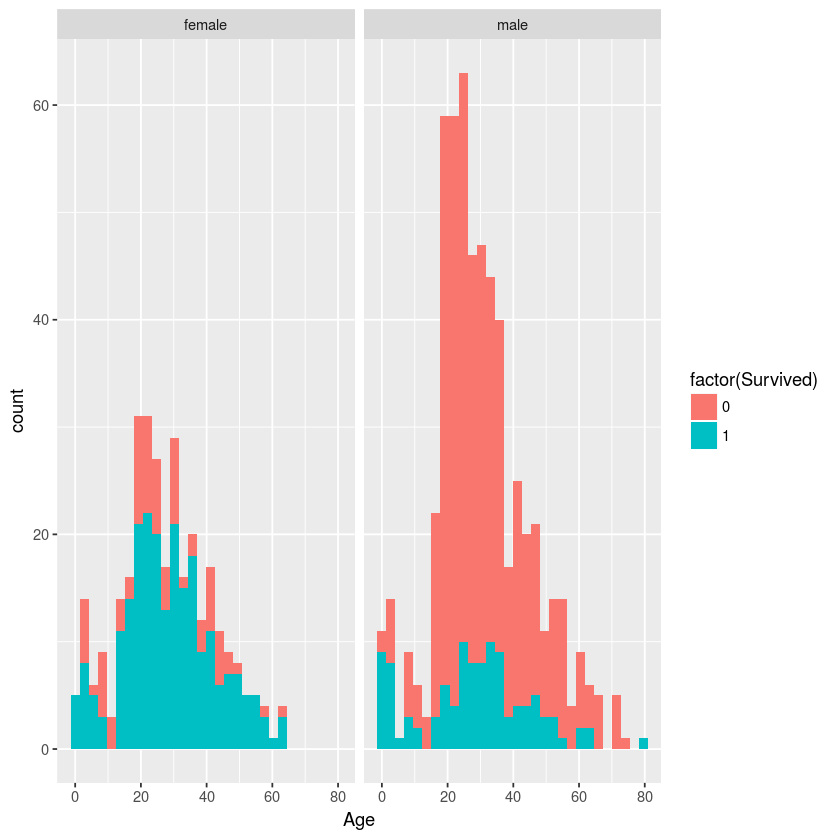

In [20]:
ggplot(full[1:891, ], aes(Age, fill = factor(Survived)))+
geom_histogram()+
facet_grid(.~Sex)

In [21]:
# Create the column child, and indicate whether child or adult
full$Child[full$Age < 18] <- 'Child'
full$Child[full$Age >= 18] <- 'Adult'

table(full$Child, full$Survived)

       
          0   1
  Adult 488 270
  Child  61  72

In [22]:
full$Mother <- 'Not Mother'
full$Mother[full$Sex == 'female' & full$Parch>0 & full$Age > 18 & full$Title!= 'Miss'] <- 'Mother'

table(full$Mother, full$Survived)

            
               0   1
  Mother      20  50
  Not Mother 529 292

In [23]:
# Convert mother and Child variables as factors
full$Child <- factor(full$Child)
full$Mother <- factor(full$Mother)

md.pattern(full)

Warning message in data.matrix(x):
“NAs introduced by coercion”Warning message in data.matrix(x):
“NAs introduced by coercion”Warning message in data.matrix(x):
“NAs introduced by coercion”

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Surname,⋯,Family,FsizeD,Child,Mother,Ticket,Survived,Deck,Name,Cabin,
150,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,0,0,2
61,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,0,1,0,0,3
54,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,0,1,1,0,0,3
511,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,0,0,0,3
30,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,0,0,1,0,0,4
235,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,0,0,0,0,4
176,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,0,1,0,0,0,4
92,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,0,0,0,0,0,5
,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,352,418,1014,1309,1309,4402


## Session Summary

str(full)

In [27]:
names(full)

[1] "PassengerId" "Survived"    "Pclass"      "Name"        "Sex"        
 [6] "Age"         "SibSp"       "Parch"       "Ticket"      "Fare"       
[11] "Cabin"       "Embarked"    "Title"       "Surname"     "Fsize"      
[16] "Family"      "FsizeD"      "Deck"        "Child"       "Mother"

In [26]:
train <- full[1:891, ]
test <- full[892:1309, ]

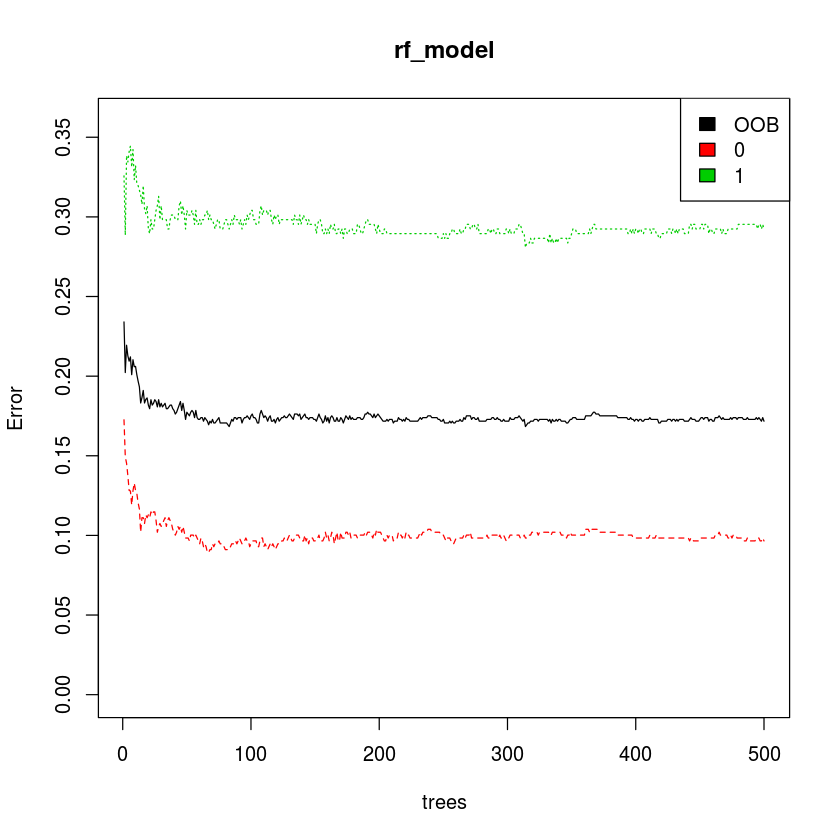

In [32]:
set.seed(891)
rf_model <- randomForest(factor(Survived) ~ Pclass + Sex + Age+ SibSp+ Parch + Fare + Embarked + Title + FsizeD + Child + Mother, data = train)

plot(rf_model, ylim = c(0, 0.36))
legend('topright', colnames(rf_model$err.rate), col = 1:3, fill=1:3)

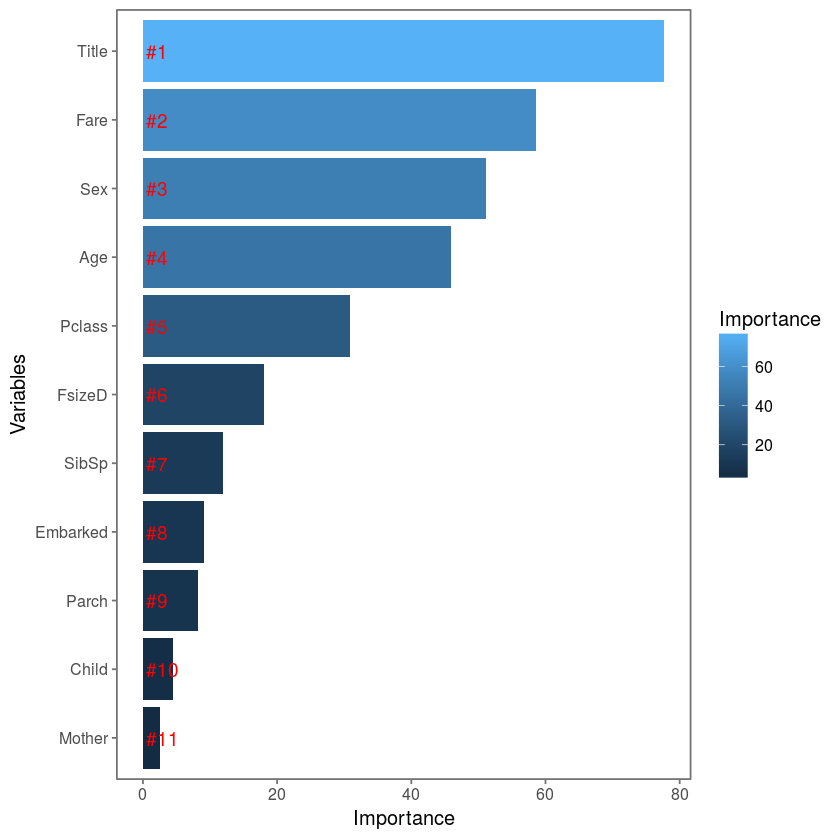

In [34]:
importance <- importance(rf_model)
varImportance <- data.frame(Variables = row.names(importance), Importance = round(importance[, 'MeanDecreaseGini'], 2))

rankImportance <- varImportance %>% mutate(Rank = paste0('#', dense_rank(desc(Importance))))

ggplot(rankImportance, aes(x = reorder(Variables, Importance),
                          y = Importance, fill = Importance))+
geom_bar(stat = 'identity')+
geom_text(aes(x = Variables, y = 0.5, label = Rank), hjust = 0, vjust = 0.55, size = 4, colour = 'red')+
labs(x = 'Variables')+
coord_flip()+
theme_few()

In [36]:
prediction <- predict(rf_model, test)
solution <- data.frame(PassengerID = test$PassengerId, Survived = prediction)
solution

,PassengerID,Survived
892,892,0
893,893,0
894,894,0
895,895,0
896,896,1
897,897,0
898,898,1
899,899,0
900,900,1
901,901,0


In [42]:
table((solution$Survived == full$Survived))

Warning message in is.na(e1) | is.na(e2):
“longer object length is not a multiple of shorter object length”Warning message in `==.default`(solution$Survived, full$Survived):
“longer object length is not a multiple of shorter object length”


FALSE  TRUE 
  428   463 